# 1-4,时间序列数据建模流程范例

国内的新冠肺炎疫情从发现至今已经持续 3 个多月了，这场起源于吃野味的灾难给大家的生活造成了诸多方面的影响。

有的同学是收入上的，有的同学是感情上的，有的同学是心理上的，还有的同学是体重上的。

那么国内的新冠肺炎疫情何时结束呢？什么时候我们才可以重获自由呢？

本篇文章将利用 `TensorFlow2.0` 建立时间序列 `RNN` 模型，对国内的新冠肺炎疫情结束时间进行预测。

![](./data/疫情前后对比.png)

### 一，准备数据

本文的数据集取自 `tushare`，数据集在本项目的 `data` 目录下。

![](./data/1-4-%E6%96%B0%E5%A2%9E%E4%BA%BA%E6%95%B0.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, losses, metrics, callbacks

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 [Text(-10.0, 0, '2020-03-01'),
  Text(0.0, 0, '2020-01-24'),
  Text(10.0, 0, '2020-02-03'),
  Text(20.0, 0, '2020-02-13'),
  Text(30.0, 0, '2020-02-23'),
  Text(40.0, 0, '2020-03-04'),
  Text(50.0, 0, '')])

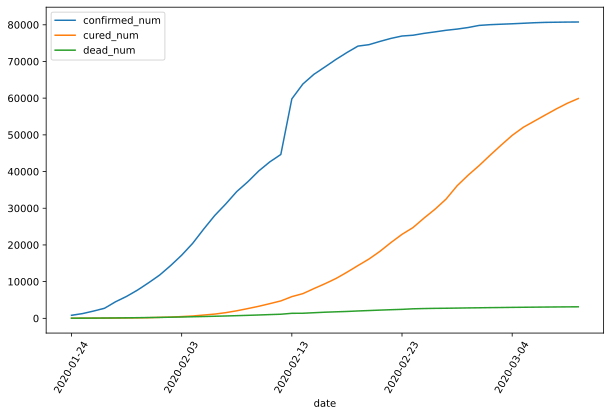

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./data/covid-19.csv", sep="\t")
df.plot(x="date", y=["confirmed_num", "cured_num", "dead_num"], figsize=(10, 6))
plt.xticks(rotation=60)

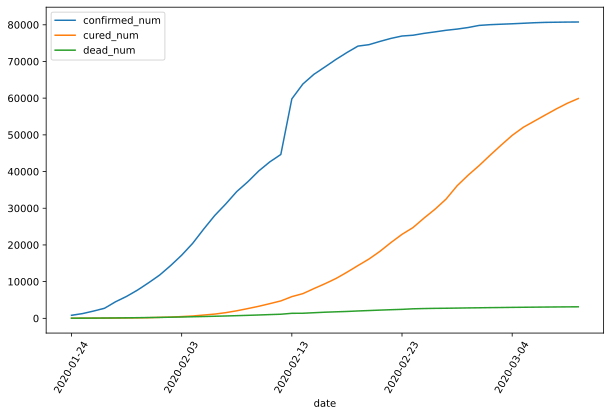

In [3]:
df_data = df.set_index("date")
df_diff = df_data.diff(periods=1).dropna()
df_diff = df_data.reset_index()

df_diff.plot(x="date", y=["confirmed_num", "cured_num", "dead_num"], figsize=(10, 6))
plt.xticks(rotation=60)
df_diff = df_diff.drop("date", axis=1).astype("float32")

In [4]:
# 用某日前 8 天窗口数据作为输入预测该日数据

WINDOW_SIZE = 8


def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE, drop_remainder=True)
    return dataset_batched


ds_data = (
    tf.data.Dataset.from_tensor_slices(tf.constant(df_diff.values, dtype=tf.float32))
    .window(WINDOW_SIZE, shift=1)
    .flat_map(batch_dataset)
)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(df_diff.values[WINDOW_SIZE:], dtype=tf.float32)
)

# 数据较小，可以将全部训练数据放入到一个 batch 中，提升性能
ds_train = tf.data.Dataset.zip((ds_data, ds_label)).batch(38).cache()

2022-05-03 20:14:36.032795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 20:14:36.058687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 20:14:36.058865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 20:14:36.059642: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### 二，定义模型

使用 Keras 接口有以下3种方式构建模型：使用 Sequential 按层顺序构建模型，使用函数式 API 构建任意结构模型，继承 Model 基类构建自定义模型。

此处选择使用函数式 API 构建任意结构模型。

In [5]:
# 考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)

    def call(self, x_input, x):
        x_out = tf.maximum((1 + x) * x_input[:, -1, :], 0.0)
        return x_out

    def get_config(self):
        config = super(Block, self).get_config()
        return config

In [6]:
tf.keras.backend.clear_session()

x_input = layers.Input(shape=[None, 3], dtype=tf.float32)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3))(x_input)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3))(x)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3))(x)
x = layers.LSTM(3, input_shape=(None, 3))(x)
x = layers.Dense(3)(x)

x = Block()(x_input, x)
model = models.Model(inputs=[x_input], outputs=[x])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, None, 3)      84          ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, None, 3)      84          ['lstm[0][0]']                   
                                                                                                  
 lstm_2 (LSTM)                  (None, None, 3)      84          ['lstm_1[0][0]']                 
                                                                                              

### 三，训练模型

训练模型通常有 3 种方法，内置 `fit` 方法，内置 `train_on_batch` 方法，以及自定义训练循环。此处我们选择最常用也最简单的内置 `fit` 方法。

> 注：循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果。

In [7]:
# 自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self, y_true, y_pred):
        err_percent = (y_true - y_pred) ** 2 / (tf.maximum(y_true ** 2, 1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent

    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

In [8]:
import os
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=MSPE(name="MSPE"))

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("data", "autograph", stamp)

tb_callback = callbacks.TensorBoard(logdir, histogram_freq=1)
# 如果 loss 在 100 个 epoch 后没有提升，学习率减半。
lr_callback = callbacks.ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=100
)
# 当 loss 在 200 个 epoch 后没有提升，则提前终止训练。
stop_callback = callbacks.EarlyStopping(monitor="loss", patience=200)
callback_list = [tb_callback, lr_callback, stop_callback]

history = model.fit(ds_train, epochs=500, callbacks=callback_list)

Epoch 1/500


2022-05-03 20:14:41.501290: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8400


2/2 [==============================] - 5s 236ms/step - loss: 0.0132 - lr: 0.0100
Epoch 2/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0107 - lr: 0.0100
Epoch 3/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0091 - lr: 0.0100
Epoch 4/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0081 - lr: 0.0100
Epoch 5/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0074 - lr: 0.0100
Epoch 6/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0071 - lr: 0.0100
Epoch 7/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0069 - lr: 0.0100
Epoch 8/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0068 - lr: 0.0100
Epoch 9/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0068 - lr: 0.0100
Epoch 10/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0068 - lr: 0.0100
Epoch 11/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0069 - lr: 0.01

### 五，使用模型

此处我们使用模型预测疫情结束时间，即 新增确诊病例为 0 的时间。

In [9]:
dfresult = df_diff[["confirmed_num", "cured_num", "dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
42,80552.0,53726.0,3042.0
43,80651.0,55404.0,3070.0
44,80695.0,57065.0,3097.0
45,80735.0,58600.0,3119.0
46,80754.0,59897.0,3136.0


In [10]:
# 预测此后 100 天的新增走势，将其结果添加到 dfresult 中
for i in range(100):
    arr_predict = model.predict(
        tf.constant(tf.expand_dims(dfresult.values[-38:, :], axis=0))
    )
    dfpredict = pd.DataFrame(
        tf.cast(tf.floor(arr_predict), tf.float32).numpy(), columns=dfresult.columns
    )
    dfresult = dfresult.append(dfpredict, ignore_index=True)

/tmp/ipykernel_47706/4201210393.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfresult = dfresult.append(dfpredict, ignore_index=True)


In [11]:
dfresult.query("confirmed_num==0").head()

,confirmed_num,cured_num,dead_num


In [12]:
dfresult.query("cured_num==0").head()

,confirmed_num,cured_num,dead_num


In [13]:
dfresult.query("dead_num==0").head()

,confirmed_num,cured_num,dead_num


### 六，保存模型

推荐使用 TensorFlow 原生方式保存模型。

In [14]:
model.save("./data/tf_model_saved_model", save_format="tf")
print("export saved model.")

2022-05-03 20:19:58.487317: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./data/tf_model_saved_model/assets


INFO:tensorflow:Assets written to: ./data/tf_model_saved_model/assets


export saved model.


In [15]:
model_loaded = tf.keras.models.load_model("./data/tf_model_saved_model", compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer, loss=MSPE(name="MSPE"))
model_loaded.predict(ds_train)

array([[ 9921.075  ,   184.30902,   220.32047],
       [12069.687  ,   279.1581 ,   251.35152],
       [14719.879  ,   353.5284 ,   314.448  ],
       [17611.648  ,   511.9695 ,   373.40698],
       [20921.062  ,   681.1889 ,   439.60657],
       [24898.91   ,   961.42487,   506.8405 ],
       [28680.219  ,  1242.7386 ,   582.3494 ],
       [31897.506  ,  1659.859  ,   657.8583 ],
       [35362.51   ,  2209.5527 ,   746.81396],
       [38077.195  ,  2855.173  ,   838.87274],
       [41120.46   ,  3536.362  ,   939.2065 ],
       [43645.77   ,  4307.0107 ,  1050.9183 ],
       [45708.395  ,  5108.917  ,  1151.2521 ],
       [61217.496  ,  6371.0566 ,  1413.9816 ],
       [65360.152  ,  7246.255  ,  1427.4283 ],
       [68063.57   ,  8726.116  ,  1575.343  ],
       [70119.03   , 10152.086  ,  1722.2234 ],
       [72215.44   , 11687.994  ,  1830.832  ],
       [74148.06   , 13528.929  ,  1932.2002 ],
       [75938.4    , 15494.892  ,  2072.8743 ],
       [76338.64   , 17412.354  ,  2190.